In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Loading data

In [2]:
# import own scripts
import util.preprocess_data as prepData
import util.load_data as loadData
import util.modeling as modeling
import util.visualize_data as vizData

C:\Users\lpsze\anaconda3\envs\QB_hackathon\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# data handling
import os
import numpy as np
from PIL import Image

# data viz
import matplotlib.pyplot as plt

# modeling
import torch

# hyperparam optimization
from ray import tune

In [4]:
config = {
    # basic infos
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": True,
    "save": False,
    
    # k-fold cross val settings
    "artificial_test_size": 0.15,
    "k_cv": 5, # must be bigger than 1
    
    # test set settings
    "official_test": False,
    "batch_size": 16,
    
    # preprocessing
    "resize": True, # resize images from (64, 64) to (224, 224)
    "apply_CLAHE": False, # improve image contrast
}

In [5]:
# ensure reproducibility (for meaningful hyperparameter selection that does not depend on random seed behavior)
modeling.set_reproducible()

# initialise objects for training
_, _, tstloader = modeling.init_data(config)

# Predicting

In [6]:
import util.inference as inference
import util.modeling as modeling
import util.GradCam as GradCam
from tqdm import tqdm 

In [7]:
paths_to_images = tstloader.dataset.metadata.path.tolist()
y_true = tstloader.dataset.metadata.plume.tolist()  # True labels (0 or 1)
y_hat = []
best_models = []
y_pred_probs = []  # Predicted probabilities for class 1
path_to_models = "models/ensemble_with_artifical_test/" 
device = GradCam.get_device()

In [8]:
for path in tqdm(paths_to_images):
    prob, lbl, best_model = inference.infer_mobilenet(path_to_models=path_to_models, path_to_img=path, device=device)
    y_pred_probs.append(prob)
    y_hat.append(lbl)
    best_models.append(best_model)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:46<00:00,  1.38it/s]


# Plotting ROC

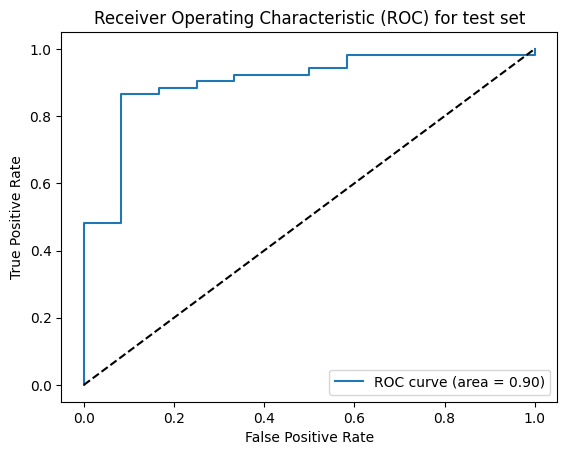

In [9]:
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Compute the AUC score
auc_score = roc_auc_score(y_true, y_pred_probs)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for test set')
plt.legend(loc='lower right')
plt.show()

# Plotting models certanity that this is plume

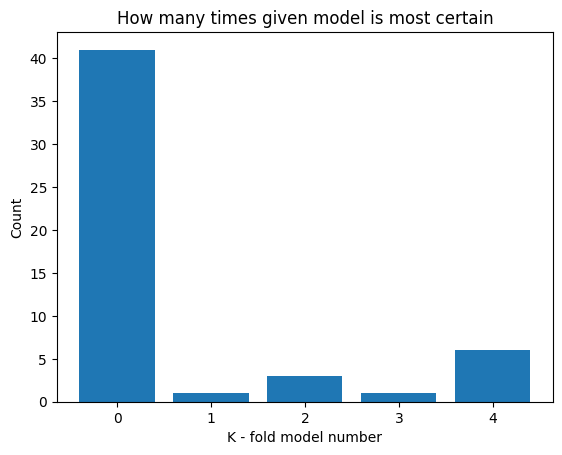

In [10]:
# Get unique values and their counts
plumes = [i==1 for i in y_true]
filtered_values = [value for value, include in zip(best_models, plumes) if include]

unique_values, value_counts = np.unique(filtered_values, return_counts=True)

# Plotting the bar chart
plt.bar(unique_values, value_counts)

# Adding labels and title
plt.xlabel('K - fold model number')
plt.ylabel('Count')
plt.title('How many times given model is most certain')

# Display the chart
plt.show()

# Plotting distribiution of probas

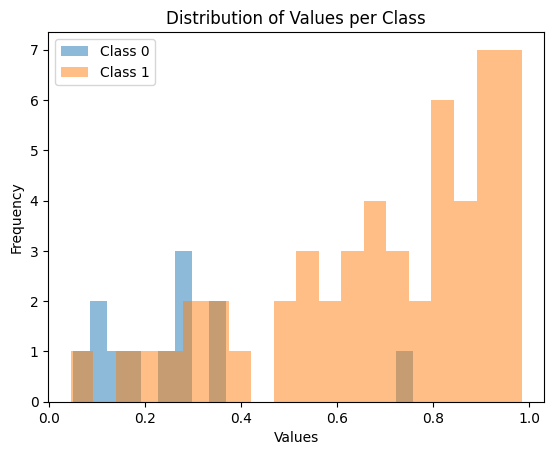

In [11]:
# Separate values based on the class
class_0_values = [value for value, group in zip(y_pred_probs, y_true) if group == 0]
class_1_values = [value for value, group in zip(y_pred_probs, y_true) if group == 1]

# Plotting the distributions
plt.hist(class_0_values, bins=20, alpha=0.5, label='Class 0')
plt.hist(class_1_values, bins=20, alpha=0.5, label='Class 1')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values per Class')

# Adding legend
plt.legend()

# Display the plot
plt.show()

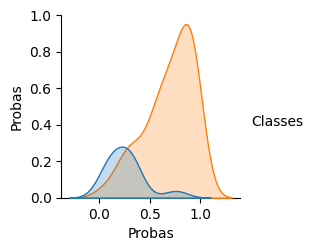

In [13]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({'Probas': y_pred_probs, 'Classes': y_true})
sns.pairplot(df[["Probas", "Classes"]], hue = "Classes")

# Predicting on test set

In [18]:
path_to_test_set = "images_test/images/"
test_y_pred_probs = []  # Predicted probabilities for class 1
path_final = []
path_to_models = "models/ensemble_without_artificial_test/" 
device = GradCam.get_device()
file_list = os.listdir(path_to_test_set)

In [19]:
for img_name in tqdm(file_list):
    path = path_to_test_set + img_name
    prob, lbl, best_model = inference.infer_mobilenet(path_to_models=path_to_models, path_to_img=path, device=device)
    
    test_y_pred_probs.append(prob)
    path_final.append("images/"+img_name)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [01:17<00:00,  1.40it/s]


In [20]:
df = pd.DataFrame({'path': path_final, 'prediction_score': y_pred_probs})
df.to_csv('team_6.csv', index=False, sep=',')

(array([14.,  6.,  7.,  4.,  2.,  3.,  4.,  4.,  1.,  3.,  0.,  2.,  2.,
         1.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  7.,  4.,  2.,
         3.,  4.,  8.,  9.]),
 array([0.01110741, 0.04353914, 0.07597087, 0.1084026 , 0.14083434,
        0.17326607, 0.2056978 , 0.23812953, 0.27056126, 0.302993  ,
        0.33542473, 0.36785646, 0.40028819, 0.43271992, 0.46515166,
        0.49758339, 0.53001512, 0.56244685, 0.59487859, 0.62731032,
        0.65974205, 0.69217378, 0.72460551, 0.75703725, 0.78946898,
        0.82190071, 0.85433244, 0.88676417, 0.91919591, 0.95162764,
        0.98405937]),
 <BarContainer object of 30 artists>)

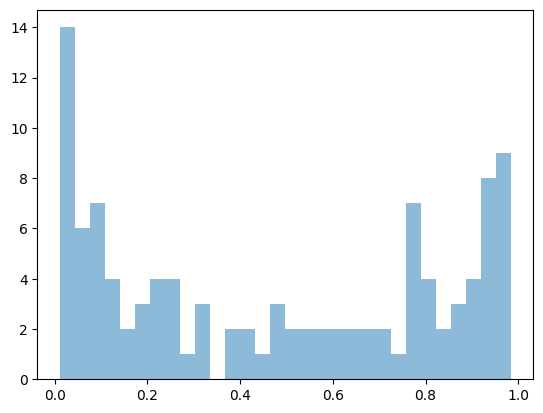

In [22]:
plt.hist(y_pred_probs, bins=30, alpha=0.5, label='Class 0')